# *A Bayesian workflow for mitigation analysis and decision making with epidemiological models*

This notebook contains all of the code used to produce the results and figures included in the paper

## Setting: Washington State -- November 1, 2020

### Load dependencies

In [1]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

## Data processing

Cumulative case, hospitalization, and death data from [COVID-19 Forecast Hub](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md)

In [2]:
location = "Washington"
# BETTER_NAMES = {'Cases': 'Infected',
#                 'Hospitalizations': 'Hospitalized',
#                 'Deaths': 'Dead'}
# ## instantiate, making sure no dates are skipped between start and end (could be found dynamically)
# full_dataset = pd.DataFrame({'date':pd.date_range(start='1/22/2020', end='3/29/2024')})

# ## fill the instantiated dataset
# for i in ['Cases','Hospitalizations','Deaths']:
#     all_data = pd.read_csv(f'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20{i}.csv')
#     subset   = all_data[all_data.location_name == location].groupby("date")["value"].sum().reset_index()
#     subset.date = pd.to_datetime(subset.date)
#     subset['cumsum'] = subset.value.cumsum()
#     full_dataset = full_dataset.merge(subset[['date','cumsum']], how='outer', on='date').rename(columns={'cumsum':BETTER_NAMES[i]})

# full_dataset[(full_dataset.date >= '2021-06-01') & (full_dataset.date < '2021-09-06')].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

# # Save full dataset
# full_dataset.to_csv('full_dataset.csv', index=False)

# Read full dataset
full_dataset = pd.read_csv('full_dataset.csv')

## Define a function to select a subset of the data
def get_data_between(start='2020-11-01',end='2020-12-31'):
    return full_dataset[(full_dataset.date >= start) & (full_dataset.date < end)].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

### Gather population values and initial conditions

Population values from [Census Reporter - Washington State](https://censusreporter.org/profiles/04000US53-washington/)

Initial conditions estimated from [COVID-19 Forecast Hub](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md)

In [3]:
# Population
WA_total_pop = 7_785_786

# Initial conditions `all_initials = [E0, I0, R0, H0, D0]`
cumul_cases0 = 111_848.0
cumul_hosp0 = 3168.0
all_initials = [4_000.0, 7_000.0, 110_000.0, 450.0, 2_353.0]

### Define a function to plot results

In [4]:
def plot_results_and_data(results, data):
    # Plot the result for cumulative cases, hospitalizations, and deaths
    nice_labels={"deceased_observable_state": "Deaths", "Cumulative_hosp_state": "Cumul Hosp", "Cumulative_cases_state": "Cumul Cases"}
    schema = plots.trajectories(results["data"], 
                                keep=["deceased_observable_state", "Cumulative_hosp_state", "Cumulative_cases_state"], 
                                relabel=nice_labels,
                                points=data.drop(columns=['Timestamp']).reset_index(drop=True)
                               )
    return schema

def plot_all_results(results):
    # Plot the result for all state variables
    keeper_list = ["infected_observable_state", "hospitalized_observable_state", "deceased_observable_state"]
    schema = plots.trajectories(results["data"], keep=keeper_list)
    return schema

# Model derivation and initialization

### Define units

In [5]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define model concepts

In [6]:
_susceptible = Concept(name='S', units=person_units(), identifiers={'ido': '0000514'})
_exposed = Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'})
_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})
_recovered = Concept(name='R', units=person_units(), identifiers={'ido': '0000592'})
_hospitalized = Concept(name="H", units=person_units(), identifiers={"ido": "0000511"},
                        context={"property": "ncit:C25179"})
_deceased = Concept(name="D", units=person_units(), identifiers={"ncit": "C28554"})

c = {
    'S_1': _susceptible.with_context(status="age1"),
    'S_2': _susceptible.with_context(status="age2"),
    'S_3': _susceptible.with_context(status="age3"),
    'S_4': _susceptible.with_context(status="age4"),
    
    'E_1': _susceptible.with_context(status="age1"),
    'E_2': _susceptible.with_context(status="age2"),
    'E_3': _susceptible.with_context(status="age3"),
    'E_4': _susceptible.with_context(status="age4"),
    
    'I_1': _susceptible.with_context(status="age1"),
    'I_2': _susceptible.with_context(status="age2"),
    'I_3': _susceptible.with_context(status="age3"),
    'I_4': _susceptible.with_context(status="age4"),
    
    'R_1': _susceptible.with_context(status="age1"),
    'R_2': _susceptible.with_context(status="age2"),
    'R_3': _susceptible.with_context(status="age3"),
    'R_4': _susceptible.with_context(status="age4"),
    
    'H_1': _susceptible.with_context(status="age1"),
    'H_2': _susceptible.with_context(status="age2"),
    'H_3': _susceptible.with_context(status="age3"),
    'H_4': _susceptible.with_context(status="age4"),
    
    'D_1': _susceptible.with_context(status="age1"),
    'D_2': _susceptible.with_context(status="age2"),
    'D_3': _susceptible.with_context(status="age3"),
    'D_4': _susceptible.with_context(status="age4"),
    
    "Cumulative_cases": Concept(name="Cumulative_cases", units=person_units()),
    "Cumulative_hosp": Concept(name="Cumulative_hosp", units=person_units()),
}

for concept in c:
    c[concept].name = concept

### Define model parameters with uncertainty

In [7]:
parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.42), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.37,
                                                            'maximum': 0.45})),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(WA_total_pop), units=person_units()),  # Total population

    'I0': Parameter(name='I0', value=sympy.Float(all_initials[1]), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.9*all_initials[1],
                                                            'maximum': 1.1*all_initials[1]})),  # Initial value for I
    
    'r_EI': Parameter(name='r_EI', value=sympy.Float(0.2424), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.2,
                                                            'maximum': 0.3})),  # Rate of progressing E -> I
    
    'r_IR': Parameter(name='r_IR', value=sympy.Float(0.256), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.2,
                                                            'maximum': 0.3})),  # Rate of progressing I -> R, H

    'p_IH': Parameter(name='p_IH', value=sympy.Float(0.095), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.09,
                                                            'maximum': 0.12})),  # Percent of I -> H
    
    'r_HR': Parameter(name='r_HR', value=sympy.Float(0.148), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.1,
                                                            'maximum': 0.2})),  # Rate of progressing H -> R = (1/avg_length_of_hospital_stay)
    
    'p_HD': Parameter(name='r_HD', value=sympy.Float(0.084), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.06,
                                                            'maximum': 0.095})),  # Percent of H -> D
}

### Define `SymPy` variables

In [8]:
S, E, I, R, H, D, Cumulative_cases, Cumulative_hosp, beta, N, I0, r_EI, r_IR, p_IH, r_HR, p_HD = sympy.symbols(
    'S E I R H D Cumulative_cases Cumulative_hosp beta N I0 r_EI r_IR p_IH r_HR p_HD')

### Set initial conditions

In [9]:
initials = {
    "S": Initial(concept=c["S"], expression=WA_total_pop - (sum(all_initials) - all_initials[1] + I0)),
    "E": Initial(concept=c["E"], expression=all_initials[0]),
    "I": Initial(concept=c["I"], expression=I0),
    "R": Initial(concept=c["R"], expression=all_initials[2]),
    'H': Initial(concept=c["H"], expression=all_initials[3]),
    'D': Initial(concept=c["D"], expression=all_initials[4]),
    "Cumulative_cases": Initial(concept=c["Cumulative_cases"], expression=cumul_cases0),
    "Cumulative_hosp": Initial(concept=c["Cumulative_hosp"], expression=cumul_hosp0)
}

### Define templates

In [10]:
##### S -> E
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=r_EI*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=r_IR*(1 - p_IH)*I
)


#### I -> H
ih = NaturalConversion(
    subject=c['I'],
    outcome=c['H'],
    rate_law=r_IR*p_IH*I
)


#### H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=r_HR*(1 - p_HD)*H
)


#### H -> D
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=r_HR*p_HD*H
)


### Cumulative Cases
# E -> I
ccei = ControlledProduction(
    controller=c['E'],
    outcome=c['Cumulative_cases'],
    rate_law=r_EI*E
)


### Cumulative Hospitalizations
# I -> H
chih = ControlledProduction(
    controller=c['I'],
    outcome=c['Cumulative_hosp'],
    rate_law=r_IR*p_IH*I
)

### Define observables

In [11]:
observables_seir = {
    # 'susceptible': Observable(name='susceptible', expression=S),
    'exposed': Observable(name='exposed', expression=E),
    'infected': Observable(name='infected', expression=I),
    'recovered': Observable(name='recovered', expression=R),
    'hospitalized': Observable(name='hospitalized', expression=H),
    'deceased': Observable(name='deceased', expression=D),
    'cumulative_cases': Observable(name='cumulative_cases', expression=Cumulative_cases),
    'cumulative_hosp': Observable(name='cumulative_hosp', expression=Cumulative_hosp),
}

### Define template model and save as petrinet AMR

In [12]:
seir_model = TemplateModel(
    templates=[
        se,
        ei,
        ir,
        ih,
        hr,
        hd,
        ccei,
        chih
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEIRHD base model')
)

# Save as JSON
with open("SEIRHD_base_petrinet.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Sample from model prior

### Set model path and parameters for sampling

In [17]:
model1 = "SEIRHD_base_petrinet.json"
num_iterations = 1000
num_samples = 200
start_time = 0.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]
# data_mapping = {'Infected': 'Cumulative_cases', 'Hospitalized': 'Cumulative_hosp', 'Dead': 'deceased'}
data_mapping = {'positive': 'Cumulative_cases', 'hospitalizedCurrently': 'Cumulative_hosp', 'death': 'deceased'}

# data_end_date = "2020-12-01"
# dataset = get_data_between('2020-11-01', data_end_date)
dataset = pd.read_csv("wa_data.csv")
end_time = len(dataset) + 31

### Sample from model prior and plot output

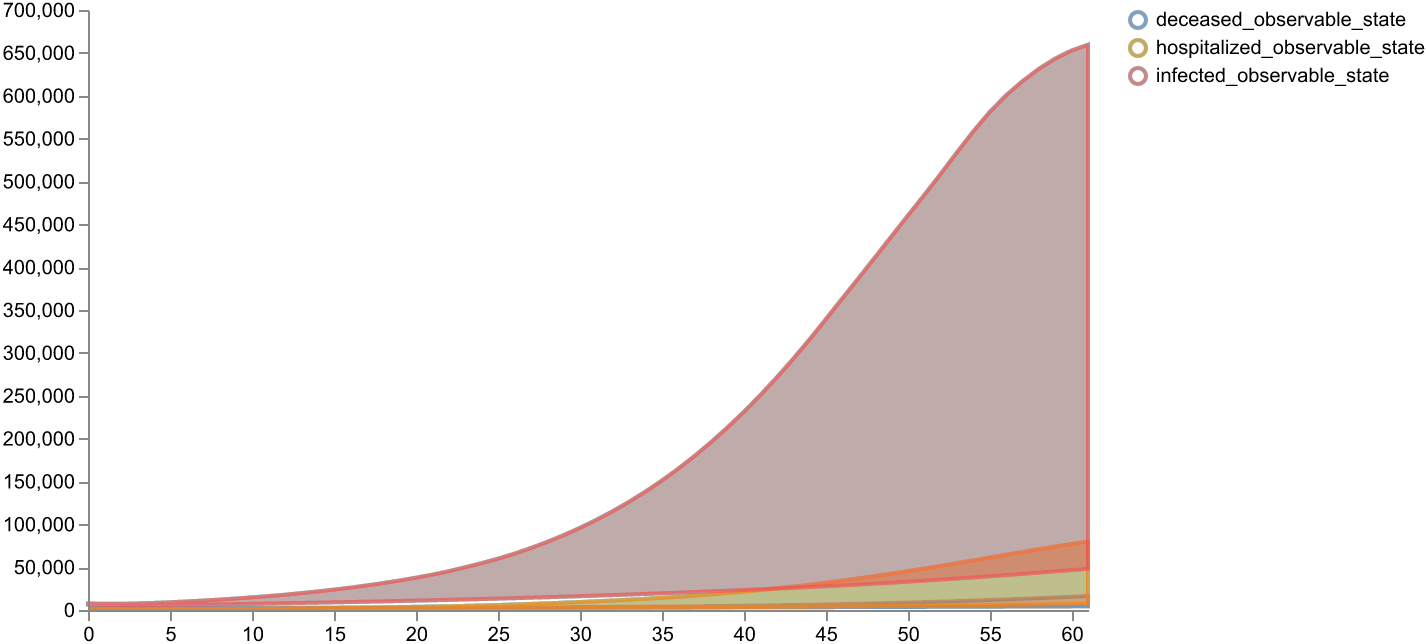

In [21]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
schema = plot_all_results(result1)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Calibrate model to data

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 29 rows of data. The first column, Timestamp, begins at 1 and ends at 30. The subsequent columns are named: death, hospitalizedCurrently, positive
{'persistent_beta': tensor(0.3789, grad_fn=<ExpandBackward0>), 'persistent_r_EI': tensor(0.2296, grad_fn=<ExpandBackward0>), 'persistent_p_IH': tensor(0.0914, grad_fn=<ExpandBackward0>), 'persistent_r_IR': tensor(0.2790, grad_fn=<ExpandBackward0>), 'persistent_p_HD': tensor(0.0706, grad_fn=<ExpandBackward0>), 'persistent_r_HR': tensor(0.1356, grad_fn=<ExpandBackward0>), 'persistent_I0': tensor(6667.8281, grad_fn=<ExpandBackward0>)}


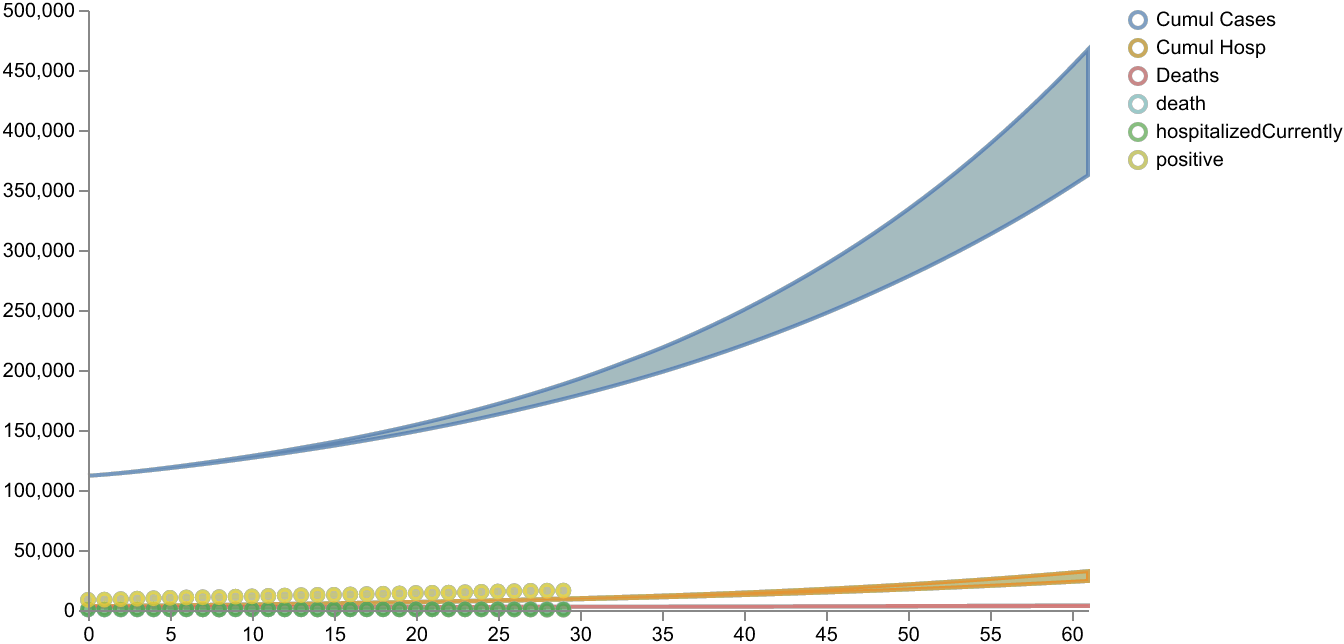

In [22]:
num_iterations = 100
calibrated_results = pyciemss.calibrate(model1, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]

print(parameter_estimates())

calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, inferred_parameters=parameter_estimates)
# display(calibrated_sample_results["data"].head())

# Plot the result with data
schema = plot_results_and_data(calibrated_sample_results, dataset)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

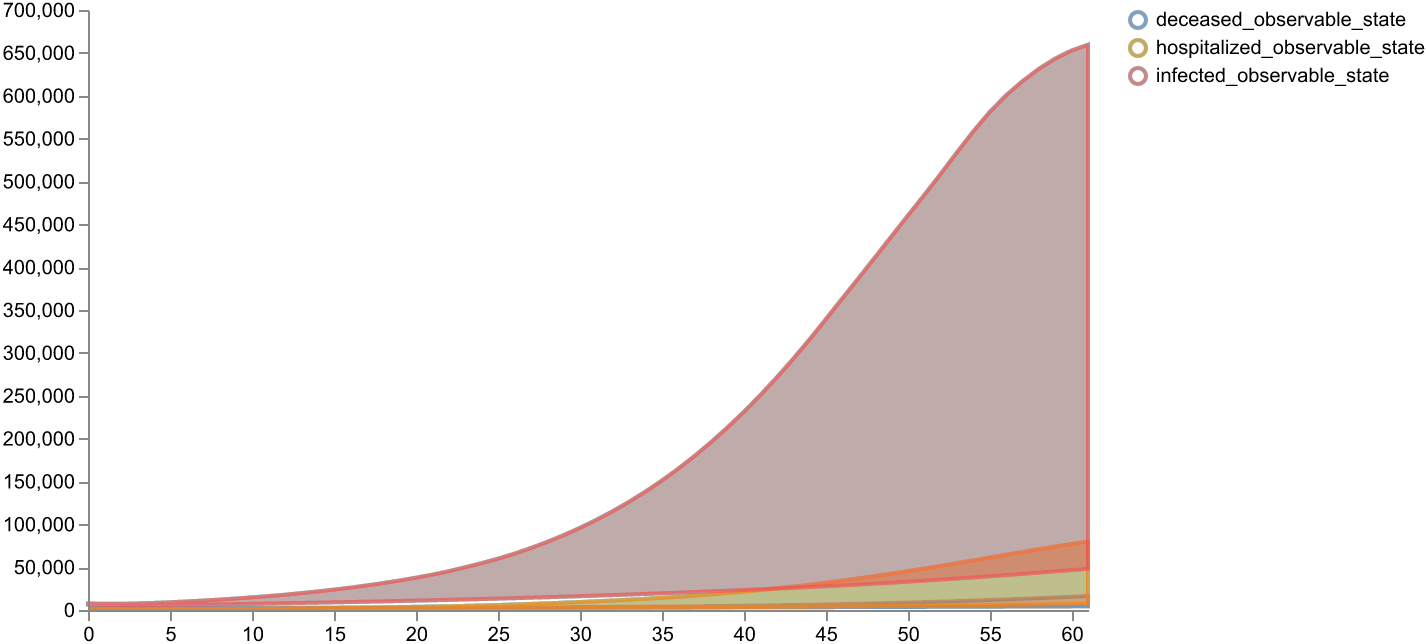

In [23]:
# Plot results for all states
schema = plot_all_results(result1)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Intervene on the model to simulate a mask mandate

Reduce the transmission rate `beta` to `0.3` on day 10 (November 11, 2020)

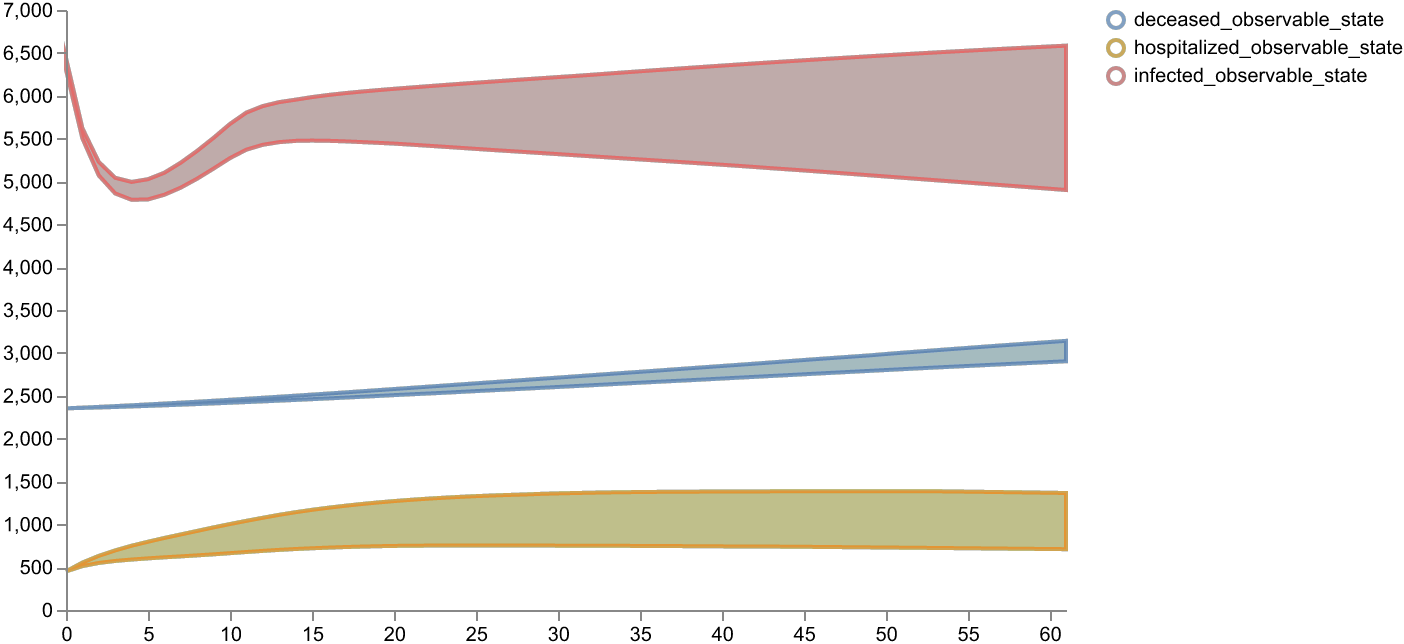

In [27]:
intervened_result = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time,
                                    inferred_parameters=parameter_estimates,
                                    static_parameter_interventions={torch.tensor(10.0): {"beta": torch.tensor(0.3)}})
# display(intervened_result["data"].head())

# Plot the result
schema = plot_all_results(intervened_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

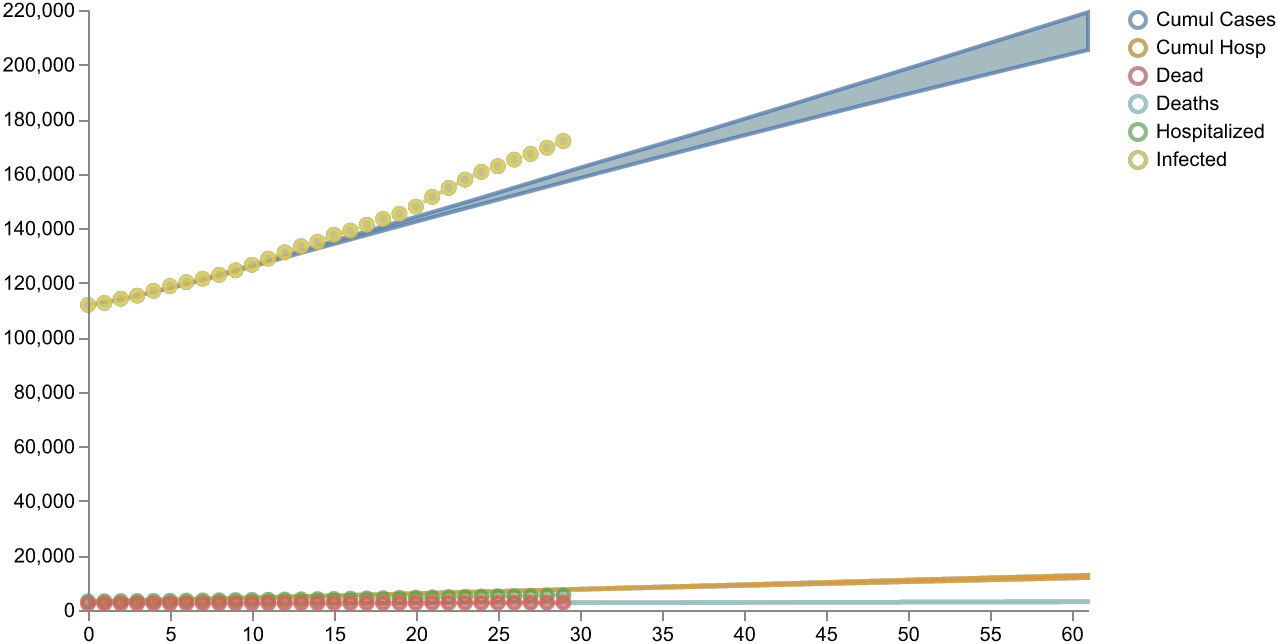

In [28]:
schema = plot_results_and_data(intervened_result, dataset)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Find the optimal time to implement a masking policy

Assume that masking reduces the transmission rate to 0.35

### Define a function to return the n-day-average of a given quantity of interest

In [23]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

### Perform optimization

In [31]:
initial_guess_interventions = 0.0
bounds_interventions = [[start_time], [end_time]]

risk_bound = 8600.0
observed_params = ["Cumulative_hosp_state"]
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: -x

static_parameter_interventions = start_time_objective(
    param_name = ["beta"],
    param_value = torch.tensor([0.37]),
)
opt_result = pyciemss.optimize(
    model1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates
)

print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

  1%|▋                                               | 2/150 [00:03<04:04,  1.66s/it]/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciem

Optimal policy: tensor([0.], dtype=torch.float64)
{'policy': tensor([0.], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 5.0
                          x: [ 0.000e+00]
                        nit: 5
      minimization_failures: 6
                       nfev: 150
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: 5.0
                                   x: [-4.441e-16]
                                nfev: 25
                               maxcv: 8600.0}



/Users/altu809/Projects/pyciemss/pyciemss/interfaces.py:964: UserWarning: Optimal intervention policy does not satisfy constraints.Check if the risk_bounds value is appropriate for given problem.Otherwise, try (i) different initial_guess_interventions, (ii) increasing maxiter/maxfeval,and/or (iii) increase n_samples_ouu to improve accuracy of Monte Carlo risk estimation. 
  warnings.warn(


### Sample with the intervention implemented at the optimal time and plot the results

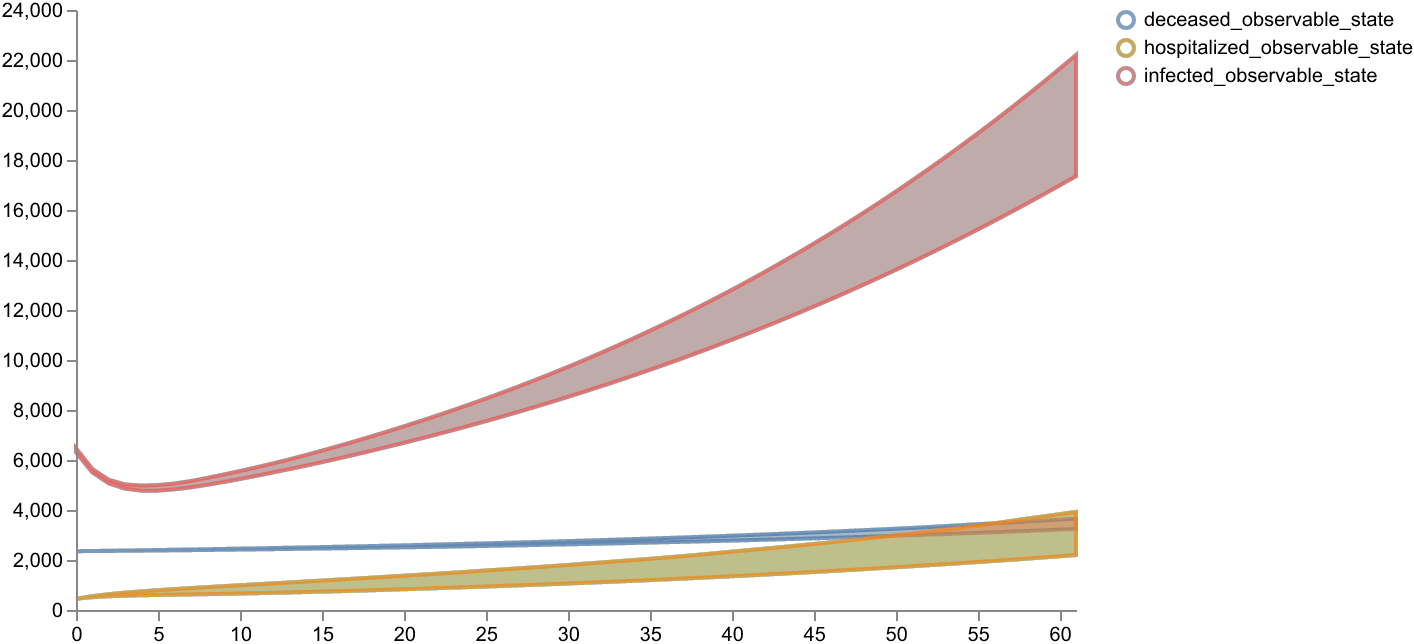

In [32]:
optimized_result = pyciemss.sample(
    model1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
)

# Plot the result
schema = plot_all_results(optimized_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

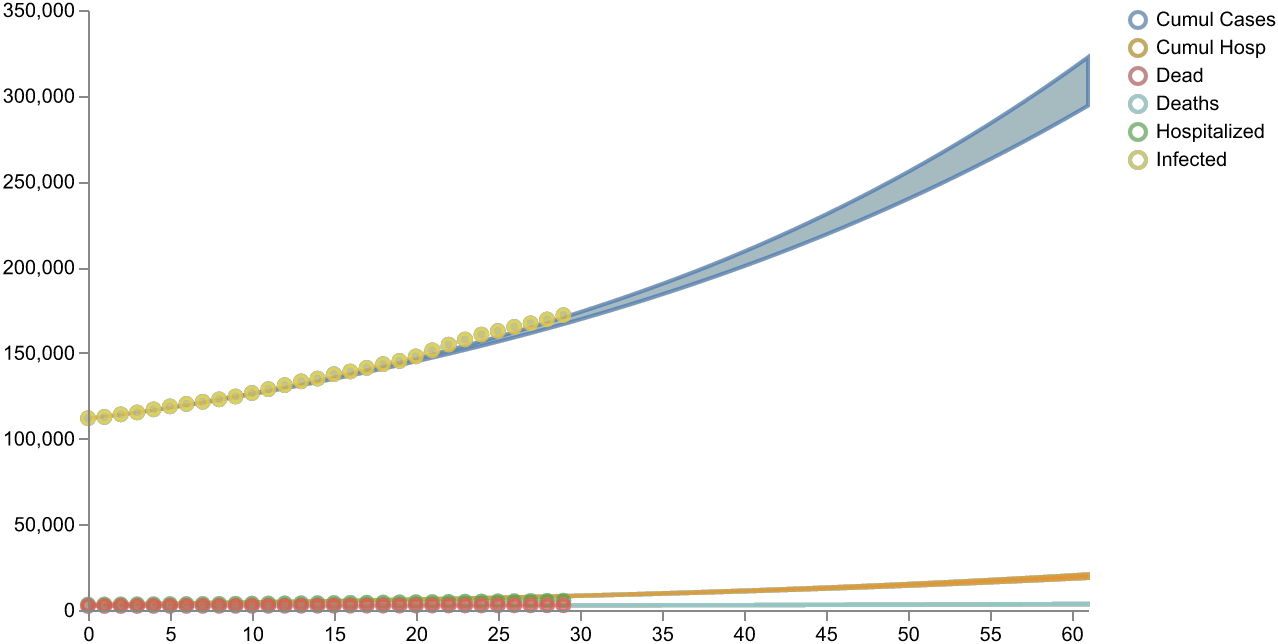

In [33]:
schema = plot_results_and_data(optimized_result, dataset)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

In [4]:
# df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
df = pd.read_csv('us-states.csv')
df = df[df['state'] == 'Washington']
df = df.drop('fips', axis=1)
df = df.sort_values('date')
print(df)

             date       state    cases  deaths
0      2020-01-21  Washington        1       0
1      2020-01-22  Washington        1       0
2      2020-01-23  Washington        1       0
4      2020-01-24  Washington        1       0
7      2020-01-25  Washington        1       0
...           ...         ...      ...     ...
61714  2023-03-19  Washington  1936946   15859
61770  2023-03-20  Washington  1936946   15859
61826  2023-03-21  Washington  1936946   15859
61882  2023-03-22  Washington  1940704   15905
61938  2023-03-23  Washington  1940704   15905

[1158 rows x 4 columns]


In [12]:
# https://covidtracking.com/data
df = pd.read_csv('all-states-history.csv')
df = df[df['state'] == 'WA']
# df = df[['date', 'death', 'hospitalizedCurrently', 'inIcuCurrently', 'positive']]
df = df[['date', 'death', 'hospitalizedCurrently', 'positive']]
df = df.sort_values('date')
print(df[84:86])
df = df.drop('date', axis=1)
df = df.iloc[84:114]
df['Timestamp'] = range(1, len(df) + 1)
df.set_index('Timestamp', inplace=True)
print(df)
df.to_csv('wa_data.csv')

             date  death  hospitalizedCurrently  positive
18812  2020-04-06  407.0                  638.0    8461.0
18756  2020-04-07  429.0                  641.0    8632.0
           death  hospitalizedCurrently  positive
Timestamp                                        
1          407.0                  638.0    8461.0
2          429.0                  641.0    8632.0
3          443.0                  655.0    9027.0
4          459.0                  650.0    9440.0
5          476.0                  642.0    9786.0
6          494.0                  649.0   10149.0
7          509.0                  642.0   10458.0
8          526.0                  527.0   10613.0
9          542.0                  387.0   10703.0
10         551.0                  645.0   11074.0
11         571.0                  595.0   11376.0
12         585.0                  622.0   11705.0
13         598.0                  518.0   12014.0
14         615.0                  586.0   12361.0
15         629.0          

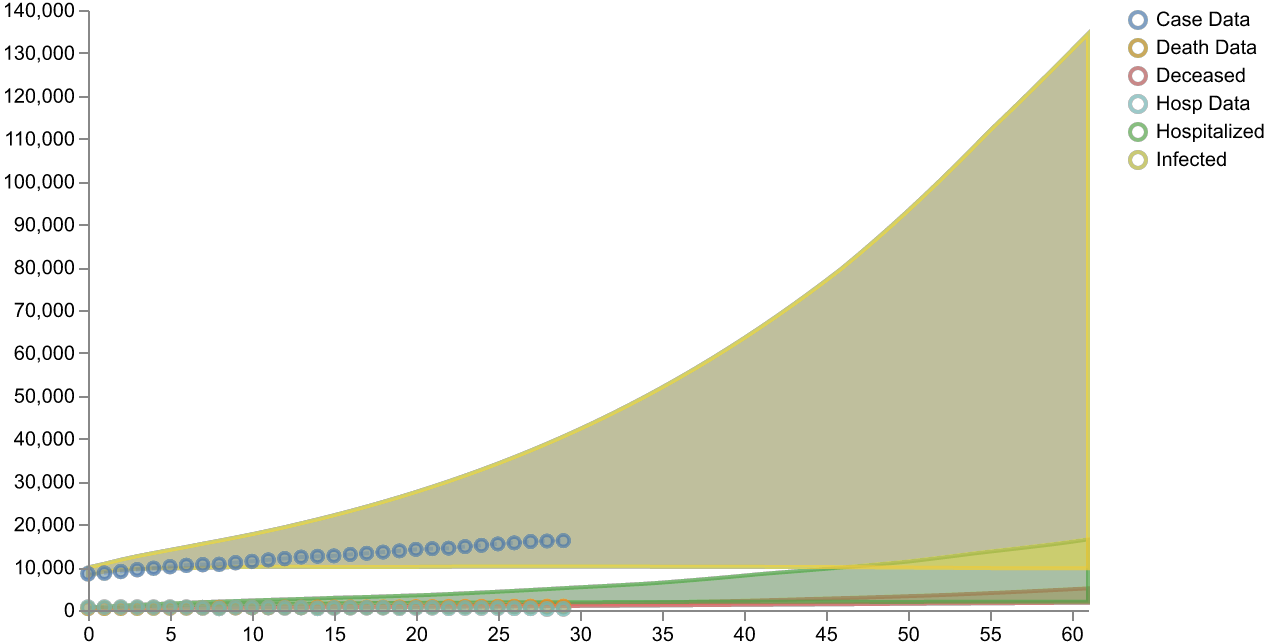

In [53]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot the result with data
nice_labels = {
        "deceased_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "positive": "Case Data",
        "hospitalizedCurrently": "Hosp Data",
        "death": "Death Data"
        }
data_df = dataset
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(result1["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "deceased_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 29 rows of data. The first column, Timestamp, begins at 1 and ends at 30. The subsequent columns are named: death, hospitalizedCurrently, positive
{'persistent_beta': tensor(0.2912, grad_fn=<ExpandBackward0>), 'persistent_r_EI': tensor(0.2012, grad_fn=<ExpandBackward0>), 'persistent_p_IH': tensor(0.0904, grad_fn=<ExpandBackward0>), 'persistent_r_IR': tensor(0.2989, grad_fn=<ExpandBackward0>), 'persistent_p_HD': tensor(0.0786, grad_fn=<ExpandBackward0>), 'persistent_r_HR': tensor(0.1058, grad_fn=<ExpandBackward0>), 'persistent_I0': tensor(8112.2671, grad_fn=<ExpandBackward0>)}


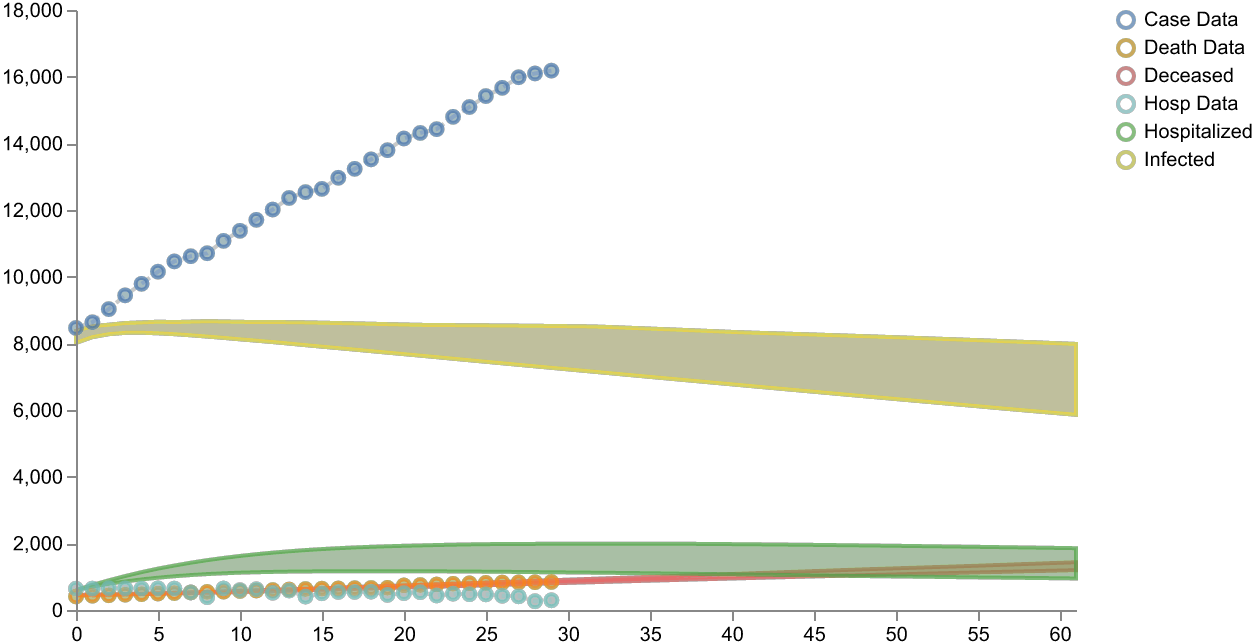

In [52]:
num_iterations = 500
dataset = pd.read_csv('wa_data.csv')
calibrated_results = pyciemss.calibrate(model1, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]

print(parameter_estimates())

calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, inferred_parameters=parameter_estimates)
# display(calibrated_sample_results["data"].head())

# Plot the result with data
nice_labels = {
        "deceased_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "positive": "Case Data",
        "hospitalizedCurrently": "Hosp Data",
        "death": "Death Data"
        }
data_df = dataset
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "deceased_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)